In [1]:
!git clone https://github.com/z-x-yang/Segment-and-Track-Anything.git
%cd /content/Segment-and-Track-Anything
!bash script/install.sh
!mkdir ./ckpt
!bash script/download_ckpt.sh
# import sys
# sys.path.append('/content/Segment-and-Track-Anything/src/groundingdino')

Cloning into 'Segment-and-Track-Anything'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 656 (delta 153), reused 137 (delta 132), pack-reused 474
Receiving objects: 100% (656/656), 230.30 MiB | 28.90 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Updating files: 100% (177/177), done.
/content/Segment-and-Track-Anything
Obtaining file:///content/Segment-and-Track-Anything/sam
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything
/content/Segment-and-Track-Anything
Obtaining GroundingDINO from git+https://github.com/IDEA-Research/GroundingDINO.git@main#egg=GroundingDINO
  Cloning https://github.com/IDEA-Research/GroundingDINO.git (to revision main) to ./src/groundingdino
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /content/Segment-and-Track-Anything/src/groundingdino
  Resolved htt

In [2]:
import sys
sys.path.append('/content/Segment-and-Track-Anything/src/groundingdino')

In [3]:

import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0

    return img_mask.astype(img.dtype)

### Set parameters for input and output

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
video_name = 'cell'

drive.mount('/content/drive/')
my_vrs_file_path = '/content/drive/MyDrive/Aria Workshop/person_a/VRS/a.vrs'

io_args = {
    'input_video': '/content/drive/MyDrive/Aria Workshop/person_a/VRS/a.mp4',
    'output_mask_dir': '/content/drive/MyDrive/aria/recording/test_seg2', # save pred masks
    'output_video': '/content/drive/MyDrive/aria/recording/test_seg2.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': '/content/drive/MyDrive/aria/recording/test_seg2.gif', # mask visualization
}

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Tuning SAM on the First Frame for Good Initialization

In [ ]:
# pip install spatial-correlation-sampler

NotImplementedError: ignored

/content/drive/MyDrive/Aria Workshop/person_a/VRS/a.mp4
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embedding

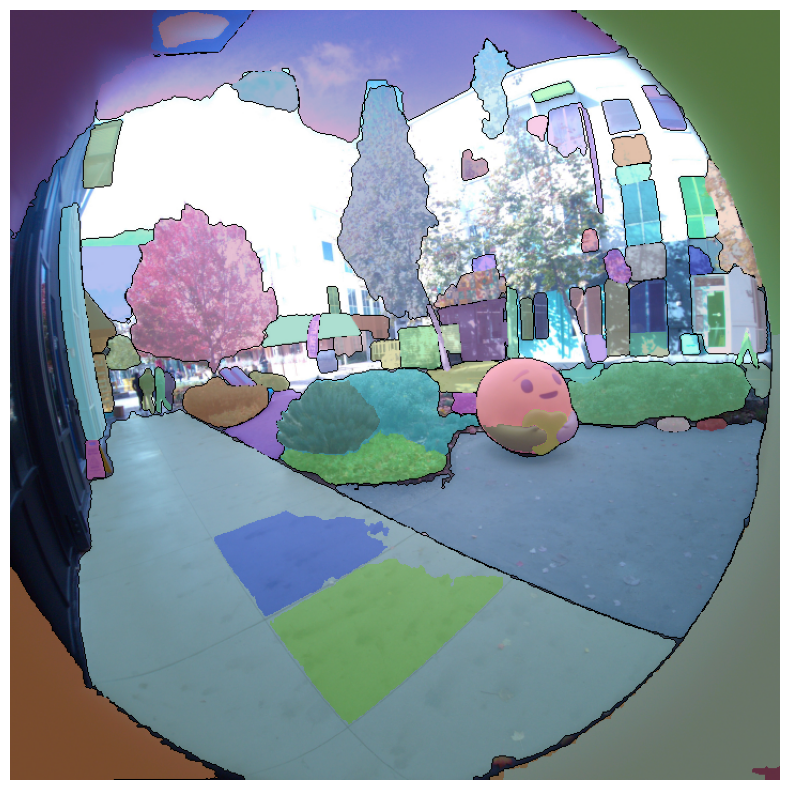

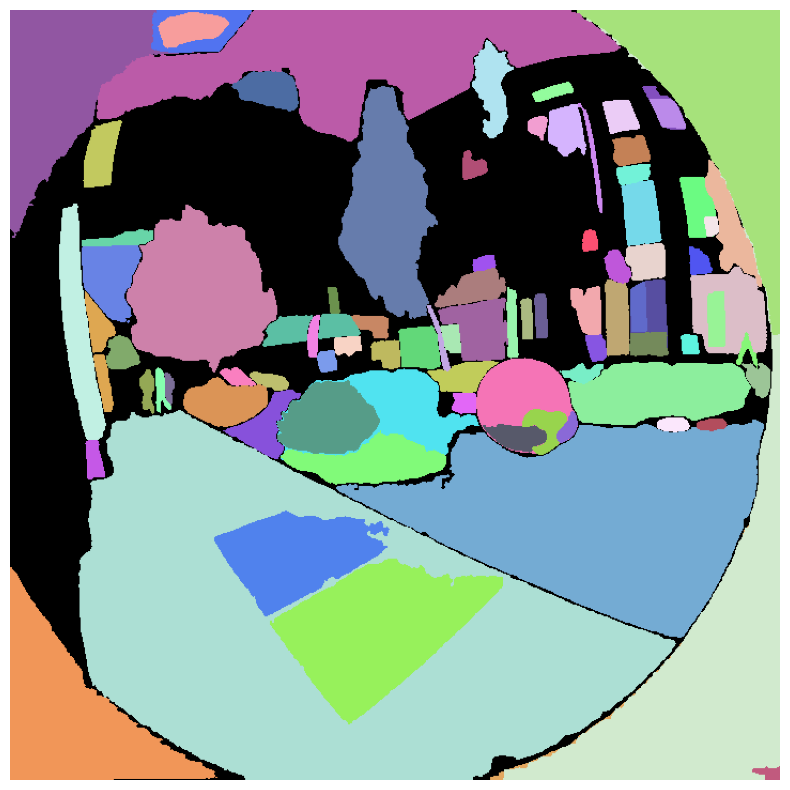

In [25]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }
cap = cv2.VideoCapture(io_args['input_video'])
print(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
i = 0
with torch.cuda.amp.autocast():
    while cap.isOpened():
        i += 1
        print(i)
        # if i%10!= 0:
        #   continue
        ret, frame = cap.read()
        height, width = frame.shape[:2]
        new_width = width // 4
        new_height = height // 4
        frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        pred_mask = segtracker.seg(frame)
        print(pred_mask)
        torch.cuda.empty_cache()
        obj_ids = np.unique(pred_mask)
        obj_ids = obj_ids[obj_ids!=0]
        print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
        break
    print(i)
    cap.release()
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

### Generate Results for the Whole Video

In [26]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 5, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80%
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        new_width = width // 4
        new_height = height // 4
        frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            pred_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        elif (frame_idx % sam_gap) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)
            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
        torch.cuda.empty_cache()
        gc.collect()
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show()

        pred_list.append(pred_mask)


        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
No module named 'spatial_correlation_sampler'
Failed to import PyTorch Correlation, For better efficiency, please install it.
final text_encoder_type: bert-base-uncased
Model loaded from ./ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
proces

In [27]:
gaze_file = "/content/drive/MyDrive/Aria Workshop/person_a/VRS/a.csv"

# read it as csv
data = []

with open(gaze_file, "r") as f:
  for l in f:
    d = l.split(",")
    data.append([float(i)/4 for i in d[:2]])

print(data)

[[338.48206058540086, 500.06449476896194], [292.93998025989396, 490.57987217937045], [407.52616961650585, 372.2025120538921], [303.52288151780436, 496.29988514065565], [354.3778588734836, 293.5459470012752], [364.36251787121427, 447.7503476632661], [345.64634750098423, 314.56538712456256]]


In [28]:
print(len(data))

7


In [29]:
objs = []
for i in range(len(pred_list)):
  x = int(data[i][0])
  y = int(data[i][0])

  obj = pred_list[i][x][y]
  objs.append(obj)

In [30]:
def find_longest_consecutive_sequence_with_k_diff_non_zero(numbers, k):
    if not numbers:
        return 0, None

    max_count = 0
    current_count = 0
    max_number = None
    last_number = None
    second_last_number = None
    second_last_count = 0
    diff_count = 0

    for i in range(len(numbers)):
        if numbers[i] == last_number or (diff_count < k and numbers[i] != 0):
            if numbers[i] != 0:
                current_count += 1
                if current_count > max_count:
                    max_count = current_count
                    max_number = numbers[i]
            if numbers[i] != last_number:
                diff_count += 1
                second_last_number = last_number
                second_last_count = current_count - (1 if numbers[i] != 0 else 0)
                last_number = numbers[i]

        else:
            current_count = current_count - second_last_count + (1 if numbers[i] != 0 else 0)
            second_last_number = last_number
            second_last_count = 1 if numbers[i] != 0 else 0
            last_number = numbers[i]
            diff_count = 1 if numbers[i] != 0 else diff_count

    return max_count, max_number

k = 2  # Allow up to 2 different numbers in the middle
length, obj = find_longest_consecutive_sequence_with_k_diff_non_zero(objs, k)

print(obj)

19


In [31]:
frame_id = []
for i in range(len(objs)):
  if objs[i] == obj:
    frame_id.append(i)

middle_frame_id = frame_id[len(frame_id) // 2]

# extract the frame from video
# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)

frame_idx = 0

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        new_width = width // 4
        new_height = height // 4
        frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == middle_frame_id:
          frame_crop = frame
        frame_idx += 1
    cap.release()


lowest_x = 999999999
highest_x = -1

loswest_y = 999999999
highest_y = -1

for i in range(pred_list[0].shape[0]):
  for j in range(pred_list[0].shape[1]):
    if pred_list[middle_frame_id][i][j] == obj:
      if lowest_x > i:
        lowest_x = i
      if highest_x < i:
        highest_x = i
      if loswest_y > j:
        loswest_y = j
      if highest_y < j:
        highest_y = j

cropped_image = frame_crop[max(lowest_x - 80, 0):min(highest_x + 80, frame_crop.shape[0]), max(loswest_y - 80, 0): min(highest_y + 80, frame_crop.shape[1])]

# Save the cropped image
cv2.imwrite('cropped_image.jpg', cropped_image)


True

In [19]:
obj

119

In [20]:
lowest_x

95

In [21]:
cropped_image.shape

(705, 720, 3)

In [22]:
highest_x

668

### Save results for visualization

In [32]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) // 4
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) // 4
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    height, width = frame.shape[:2]
    new_width = width // 4
    new_height = height // 4
    frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]

    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)

    x, y = int(data[frame_idx][0]), int(data[frame_idx][1])
    print(x, y)
    # Draw a red cross
    cross_size = 30
    red_color = (0, 0, 255)  # BGR format for red
    thickness = 4
    cv2.line(masked_frame, (x - cross_size, y), (x + cross_size, y), red_color, thickness)
    cv2.line(masked_frame, (x, y - cross_size), (x, y + cross_size), red_color, thickness)

    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

338 500
292 490
407 372
303 496
354 293
frame 4 writed
/content/drive/MyDrive/aria/recording/test_seg2.mp4 saved

finished


In [ ]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

In [ ]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()